In [23]:
from models import deep_strain_model
from datasets import base_dataset
from datasets.nifti_dataset import resample_nifti
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import center_of_mass
from datasets.base_dataset import roll_and_pad_256x256_to_center_inv
from datasets.base_dataset import _roll2center_crop
from scipy.ndimage import gaussian_filter
import numpy as np
import SimpleITK as sitk
from utils.strain_from_motion import *
from utils.utils_aha import *
import nibabel as nib
from skimage.util import montage
import matplotlib.pyplot as plt

##########################      Normalization     ######################################


def normalize(x, axis=(0, 1, 2)):
    # normalize per volume (x,y,z) frame
    mu = x.mean(axis=axis, keepdims=True)
    sd = x.std(axis=axis, keepdims=True)
    return (x - mu) / (sd + 1e-8)

######################### Constants and arguments ######################################

class CarMEN_options:
    def __init__(self):
        self.isTrain = True
        self.volume_shape = (128, 128, 16, 1)
        self.lambda_i = 0.1
        self.lambda_s = 0
        self.lambda_a = 0


Data  that will be used for training is in ACDC folder

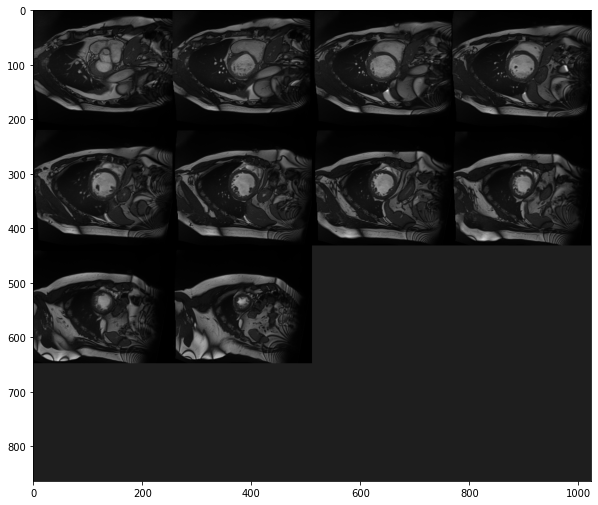

In [18]:
volume  = nib.load("ACDC/patient001/patient001_4d.nii.gz").get_fdata()
plt.figure(figsize=(10,10))
plt.imshow(montage(volume[:, :, :, 0].transpose((2,0,1))), cmap="gray")

In [25]:
# train carmen model

opt = CarMEN_options()
model = deep_strain_model.DeepStrain(Adam, opt=opt)
netME = model.get_netME()

#train model without using pretrained weights

netME.fit(x=train_dataset, epochs=100, validation_data=val_dataset)




NameError: name 'motion_estimates' is not defined